In [1]:
#%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import time
import random
import copy
from copy import deepcopy
import threading

from train_utils import *

import gym3
from procgen import ProcgenGym3Env
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
train_num_levels = 100_000 #500 #1500
train_start_level = 0
color_themes_indist = 1
color_themes_outdist = 234567

color_themes_road_indist = 2
color_themes_road_outdist = 134567

In [5]:
bs = 144 

env = ProcgenGym3Env(num=bs, env_name="testgame", num_levels=train_num_levels, start_level=train_start_level,
                    color_theme=color_themes_indist, color_theme_road=color_themes_road_indist,
                    background_noise_level=0)

building procgen...done


In [6]:
%%time

s = np.array([[.0,.0] for _ in range(bs)], dtype=np.float32)

seq_len = 200

for i in range(seq_len):
    env.act(s)
    rew, obs, first = env.observe()
    img = obs['rgb']
    info = env.get_info()


CPU times: user 2.75 s, sys: 146 ms, total: 2.89 s
Wall time: 797 ms


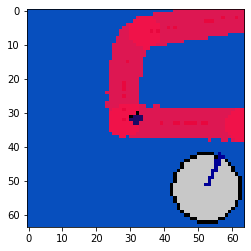

In [7]:
plt.imshow(img[14])

In [8]:
dataloader = DataLoader(env=env, bs=bs, seq_len=200)

Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.11 seconds


In [9]:
front, aux, target = dataloader.get_chunk()

In [10]:
front.shape, aux.shape, target.shape

(torch.Size([200, 144, 3, 64, 64]),
 torch.Size([200, 144, 5]),
 torch.Size([200, 144, 2]))

In [11]:
m = VizCNN(use_rnn=False).to(device);

#m = EfficientNet.from_pretrained('efficientnet-b4', in_channels=3, num_classes=2).to(device)

Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.15 seconds


In [12]:
m

VizCNN(
  (pooler): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (conv_1a): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2a): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2b): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3a): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4a): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc0): Linear(in_features=5189, out_features=512, bias=True)
  (fc1): Linear(in_featur

In [13]:
#m.load_state_dict(torch.load("m.torch"))

In [14]:
sum([torch.numel(p) for p in m.parameters()]) / 1000

3192.834

In [15]:
with torch.no_grad():
    hidden = get_hidden(bs)
    out, hidden = m(front[:6].to(device), aux[:6].to(device), hidden)

In [16]:
del front, aux, target, out, hidden

In [17]:
def testdrive(in_distribution=True, calibrate=False, use_training_wheels=False):
    
    TRAINING_WHEELS_WINDOW = 10
    
    t1 = time.time()
    m.eval()
    seq_len = 300
    n_val = 100
    val_env = ProcgenGym3Env(num=n_val, 
                            env_name="testgame", 
                            num_levels=train_num_levels, 
                            start_level=train_start_level if in_distribution else train_start_level+train_num_levels,
                            color_theme=color_themes_indist if in_distribution else color_themes_outdist,
                            color_theme_road=color_themes_road_indist if in_distribution else color_themes_road_outdist,
                            background_noise_level = 0 if in_distribution else 100
                            )
    
    s = np.array([[.0,.0] for _ in range(n_val)], dtype=np.float32)
    reward = 0
    num_collisions = 0
    wp_infractions = 0
    successful_stops = 0
    
    hidden = get_hidden(n_val)
    
    with torch.no_grad():
        for i in range(seq_len):
            val_env.act(s)
            rew, obs, first = val_env.observe()
            reward += rew.sum()
            img = obs['rgb']
            info = val_env.get_info()
            num_collisions += np.array([e['collision'] for e in info]).sum()
            wp_infractions += np.array([e['waypoint_infraction'] for e in info]).sum()
            successful_stops += np.array([e['successful_stop'] for e in info]).sum()
            
            autopilot_control = np.array([[e["autopilot_"+c] for c in control_properties] for e in info])
            
            aux = np.array([[e[a] for a in aux_properties] for e in info])

            front = torch.from_numpy(img.astype(np.float32)/255.).unsqueeze(0).permute(0,1,4,2,3).to(device)
            
            aux = torch.from_numpy(aux.astype(np.float32)).unsqueeze(0).to(device)
            
            if calibrate:
                s = autopilot_control
            else:
                out, hidden = m(front, aux, hidden)
                s = out.squeeze(0).squeeze(-1).cpu().numpy()
                s = np.clip(s, -5., 5.)
                
            if use_training_wheels and i < TRAINING_WHEELS_WINDOW:
                s = autopilot_control
        

    reward /= (n_val*seq_len)
    num_collisions /= (n_val*seq_len)
    wp_infractions /= (n_val*seq_len)
    successful_stops /= (n_val*seq_len)
    
    val_env.close()
    m.train()
    print(f"validation took {round(time.time()-t1)} seconds")
    return reward, num_collisions, wp_infractions, successful_stops

In [18]:
testdrive(in_distribution=False, calibrate=False, use_training_wheels=True)

validation took 16 seconds


(0.0491, 0.0, 0.0, 0.0)

In [19]:
loss_fn = torch.nn.MSELoss().cuda()
scaler = torch.cuda.amp.GradScaler() 
opt = torch.optim.Adam(m.parameters(), lr=3e-4)

In [20]:
import wandb

In [21]:

#wandb.init(project="carlita")

In [22]:
#wandb.watch(m)

In [23]:

def run_epoch(train=True):
    
    start_time = time.time()
    
    # Caching baseline 'perfect' scores for val use. A bit awkward placement
    autopilot_score_baseline_in_dist, autopilot_collisions_in_dist, _, ap_successful_stops_in = testdrive(in_distribution=True, calibrate=True)
    autopilot_score_baseline_out_dist, autopilot_collisions_out_dist, _, ap_successful_stops_out = testdrive(in_distribution=False, calibrate=True)
    
    m.train(train)
    t1 = time.time()
    epoch_loss, preds = [], []
    #bs = random.choice(list(bs_bptt_lookup.keys()))
    bptt = 1 #32 #random.choice([64, 72, 80, 88]) # increasing for 32x32 data #bs_bptt_lookup[bs]
    
    val_cadence = 8
    log_cadence = 4
    
    global dataloader, bs
    #dataloader = DataLoader(bs=bs) 
    log_counter = 0
    
    #hidden_reset_counter = 0
    #hidden_reset_cadence = 8
    
    while True:
        chunk = dataloader.get_chunk() # Returns a chunk instantly, begins queuing up another chunk async
        if not chunk: break
        front_container, aux_container, target_container = chunk
        chunk_len, bs, _, _, _ = front_container.shape
        len_ix = 0
        chunk_loss = []
        
        hidden = get_hidden(bs) # Resetting each chunk, ie each 800 steps or so
        
        while len_ix < chunk_len:
            
            #if hidden_reset_counter % hidden_reset_cadence == 0:
            #    hidden = get_hidden(bs)
            #    print("Resetting hidden")
            #hidden_reset_counter+=1
                
            front = front_container[len_ix:len_ix+bptt, :, :, :, :].to(device).half()
            aux = aux_container[len_ix:len_ix+bptt, :, :].to(device).half();
            target = target_container[len_ix:len_ix+bptt, :, :].to(device).half()
            len_ix += bptt*4

            with torch.cuda.amp.autocast():
                pred, hidden = m(front, aux, hidden)
                
            loss = loss_fn(target, pred); 
            chunk_loss.append(loss.item())
                
            if train:
                # Scales the loss, and calls backward() to create scaled gradients 
                scaler.scale(loss).backward() 
                
                # Unscales the gradients of optimizer's assigned params in-place
                scaler.unscale_(opt)
                # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
                torch.nn.utils.clip_grad_norm_(m.parameters(), 5.)
        
                # Unscales gradients and calls or skips optimizer.step() 
                scaler.step(opt) 
                # Updates the scale for next iteration 
                scaler.update() 
                opt.zero_grad()
                
            hidden = (hidden[0].detach(), hidden[1].detach())

        # Save and report at end of each chunk
        t2 = time.time()
        chunk_loss = np.round(np.array(chunk_loss).mean(), 4)
        epoch_loss.append(chunk_loss)
        total_seconds = round(t2 - t1)
        
        if train and log_counter % log_cadence == 0 and log_counter>1: 
            
            current_time = time.time()
            torch.save(m.state_dict(), 'm.torch')
            """wandb.log({"Chunk Loss": chunk_loss, 
                       "Seconds per iter":total_seconds, 
                       'LR':opt.param_groups[0]['lr'],
                       "Total time (min)":round((time.time()-start_time) / 60)
                      })"""
            print(f'Done with chunk. Training took {total_seconds} seconds. Chunk loss was {chunk_loss}\n')
            
        if log_counter % val_cadence == 0:
            val_score_in_dist, collisions_in_dist, wp_infractions_in_dist, stops_in = testdrive(in_distribution=True, use_training_wheels=False) 
            val_score_in_dist /= autopilot_score_baseline_in_dist
            #collisions_in_dist /= autopilot_collisions_in_dist
            #stops_in /= ap_successful_stops_in
            
            val_score_out_dist, collisions_out_dist, wp_infractions_out_dist, stops_out = testdrive(in_distribution=False, use_training_wheels=True)
            val_score_out_dist /= autopilot_score_baseline_out_dist
            #collisions_out_dist /= autopilot_collisions_out_dist
            #stops_out /= ap_successful_stops_out
            
            print(f"val score in dist: {np.round(val_score_in_dist,2)}")
            print(f"val_score_out_dist: {np.round(val_score_out_dist,2)}")
            #print(f"wp infractions in dist: {wp_infractions_in_dist}, out dist: {wp_infractions_out_dist}")
            
            """wandb.log({"val score indist":val_score_in_dist, 
                       #"val score outdist":val_score_out_dist,
                       "collisions indist":collisions_in_dist, 
                       #"collisions outdist":collisions_out_dist,
                        #"wp infractions indist":wp_infractions_in_dist, 
                       #"wp infractions outdist":wp_infractions_out_dist,
                        "stops indist":stops_in, 
                       #"stops outdist":stops_out
                      })"""
            
        t1 = t2
        log_counter+=1
    
    loss = np.array(epoch_loss).mean()
        
    return loss

In [24]:
run_epoch()

validation took 1 seconds
validation took 2 seconds
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.26 seconds
validation took 16 seconds
validation took 17 seconds
val score in dist: 0.41
val_score_out_dist: 0.2
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.29 seconds
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.27 seconds
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.29 seconds
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.31 seconds
Done with chunk. Training took 5 seconds. Chunk loss was 0.124

Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.32 seconds
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.45 seconds
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.26 seconds
Queueing chunk of size torch.Size([200, 144, 3, 64, 64]) took 1.39 seconds
Done with chunk. Training took 5 seconds. Chunk loss was 0.0891

validation took 17 seconds
validation took

KeyboardInterrupt: 